In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as tick
from matplotlib import font_manager as fm, rcParams
import seaborn as sns
import datetime
from requests import get

In [2]:
def get_data(url):
    """ Taken from the GOV.UK COVID developer page, gets JOSN data from GOV.UK API
        
        Args:
            url: API URL for GOV.UK COVID data 

        Returns:
            response: JSON data requested from url
    """
    response = get(endpoint, timeout=10)
    
    if response.status_code >= 400:
        raise RuntimeError(f'Request failed: { response.text }')
        
    return response.json()


def today_anno(data):
    """ Return's the most recent day's data and creates the annotation text
         
         Args:
            data: Dataset with vaccination data

         Returns:
            today: Pandas DataFrame with only the most recent day's data
            anno: Annotation text for the most recent point on the plot
    """

    today = data[data["date_real"]==data["date_real"].max()]
    
    if today["date_real"].iloc[0].weekday() in [0,1,2,3,6]:
        return today, f'{int(today["vaxes"].iloc[0]):,}' + " vaccinations"
        
    elif today["date_real"].iloc[0].weekday() in [4,5]:
        return today, f'{int(today["vaxes"].iloc[0]):,}' + " vaccinations\n(excl Scotland and Wales)"

def y_fmt(tick_val,pos):
    """ Function to format y axis ticks as e.g. 100,000 = 100k
         
         Args:
            tick_val: Tick value
            pos: position of tick

         Returns:
            String for tick value
    """
    
    if tick_val > 1000000:
        val = int(tick_val/1000000)
        return '{:d}M'.format(val)
    
    elif tick_val > 1000:
        val = int(tick_val/1000)
        return '{:d}k'.format(val) 
    
    else: 
        return int(tick_val)

In [15]:
endpoint = (
'https://api.coronavirus.data.gov.uk/v1/data?'
'filters=areaType=overview&'
'structure={"date":"date","cumPeopleVaccinatedFirstDoseByPublishDate":"cumPeopleVaccinatedFirstDoseByPublishDate","cumPeopleVaccinatedSecondDoseByPublishDate":"cumPeopleVaccinatedSecondDoseByPublishDate"}'
)
data = get_data(endpoint)
df=pd.json_normalize(data,"data")

#Change date from index to datetime variable and sum 1st and 2nd doses for overall doses per day 
by_date = df.groupby("date").sum().reset_index()
by_date["date_real"] = pd.to_datetime(by_date["date"]).dt.date
by_date["FirstDoseOnly"] = by_date["cumPeopleVaccinatedFirstDoseByPublishDate"] - by_date["cumPeopleVaccinatedSecondDoseByPublishDate"]
by_date["TotalDoses"] = by_date["cumPeopleVaccinatedFirstDoseByPublishDate"] + by_date["cumPeopleVaccinatedSecondDoseByPublishDate"]


#Create numpy array of all dates from 11/01/21 to 07/02/21
start_date = datetime.date(2021, 1 , 17)
end_date = datetime.date(2021, 2 , 14)
end_datetime = datetime.datetime(2021, 2 , 7,0,0,0) #Keep a datetime of the end date so annoations can be plotted precisely 
number_of_days = 29
date_list = np.asarray([(start_date + datetime.timedelta(days = day)) for day in range(number_of_days)])
x_labels = np.asarray([(start_date + datetime.timedelta(days = day)).strftime('%d/%m') for day in range(number_of_days)])

# Find out which priority group has been vaccinated
groups = [[1000000,"Care home residents + their carers"],[6500000,"over 80 + frontline health workers"],
          [8700000,"over 75"],[13400000,"over 70 and extremely vulnerable"],[16800000,"over 65"],
          [20600000,"over 60"],[25000000,"Over 55"],[29700000,"over 50"]]

today_total = int(by_date[by_date["date_real"]==by_date["date_real"].max()]["cumPeopleVaccinatedFirstDoseByPublishDate"])
past_7days = int(by_date["TotalDoses"].iloc[-1] - by_date["TotalDoses"].iloc[-7])
pop_pct = int(100*today_total/53000000)

#Set y_limit based on number of vaccinations
if today_total < 16800000: 
    y_limit = 25000000
else:
    y_limit = 35000000

for i in range(len(groups)):
    if today_total < groups[i][0]:
        current_group = groups[i][1]
        break


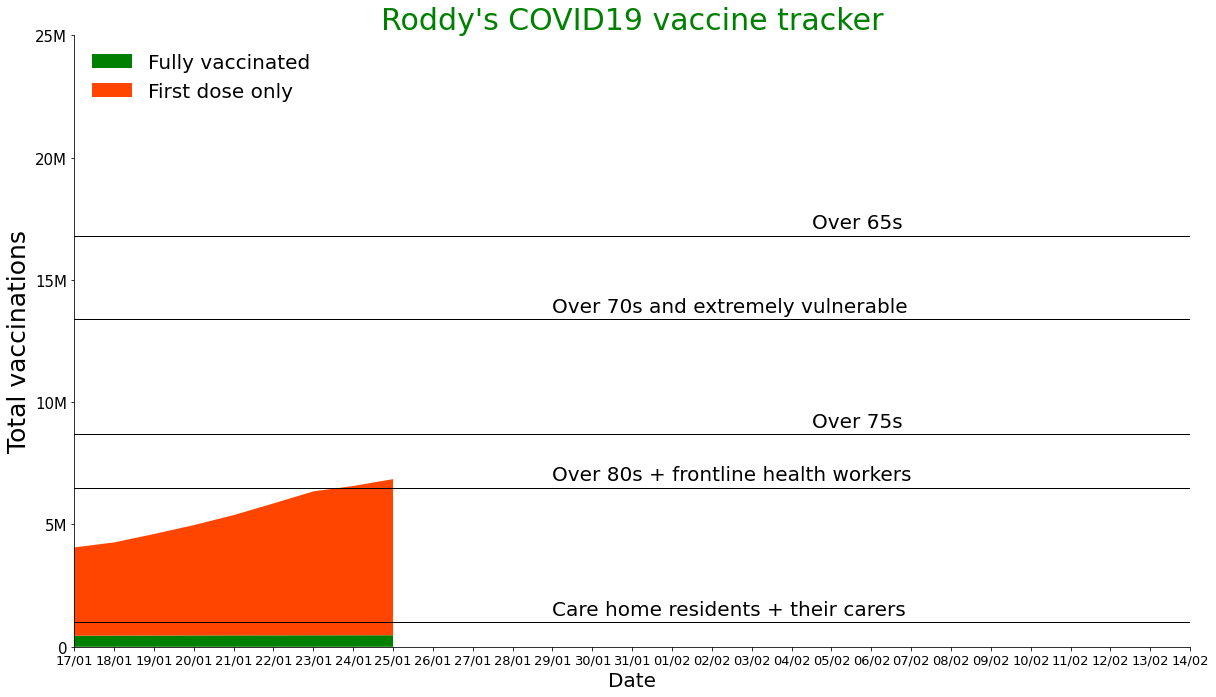

In [16]:
#Plot cumulative vaccinations per day and reference lines
fig, ax = plt.subplots(1,1,figsize=[20,11.25],facecolor="white")
ax.set_facecolor("white")

ax.stackplot(date_list[date_list <= by_date["date_real"].max() ], 
             by_date[by_date["date_real"]>= start_date]["cumPeopleVaccinatedSecondDoseByPublishDate"], 
             by_date[by_date["date_real"]>= start_date]["FirstDoseOnly"], 
            labels=["Fully vaccinated","First dose only"], colors= ["green","orangered"])

width = 1

biglabel_x = end_datetime-datetime.timedelta(days = 9)
shortlabel_x = end_datetime-datetime.timedelta(days = 2.5)

ax.plot(date_list, np.full(date_list.shape,1000000),label='_nolegend_',lw=width,c='black')
ax.text(biglabel_x,1300000,
        "Care home residents + their carers", fontsize=20)  


ax.plot(date_list, np.full(date_list.shape,6500000),label='_nolegend_',lw=width,c='black')
ax.text(biglabel_x,6800000,
        "Over 80s + frontline health workers", fontsize=20)


ax.plot(date_list, np.full(date_list.shape,8700000),label='_nolegend_',lw=width,c='black')
ax.text(shortlabel_x,9000000,
        "Over 75s", fontsize=20)

ax.plot(date_list, np.full(date_list.shape,13400000),label='_nolegend_',lw=width,c='black')
ax.text(biglabel_x,13700000,
        "Over 70s and extremely vulnerable", fontsize=20)

ax.plot(date_list, np.full(date_list.shape,16800000),label='_nolegend_',lw=width,c='black')
ax.text(shortlabel_x,17100000,
        "Over 65s", fontsize=20)

if today_total > 16800000: 
    ax.plot(date_list, np.full(date_list.shape,20600000),label='_nolegend_',lw=width,c='black')
    ax.text(shortlabel_x,20900000,
            "Over 60s", fontsize=20)

if today_total > 16800000:
    ax.plot(date_list, np.full(date_list.shape,25000000),label='_nolegend_',lw=width,c='black')
    ax.text(shortlabel_x,25300000,
            "Over 55s", fontsize=20)

if today_total > 16800000:
    ax.plot(date_list, np.full(date_list.shape,29700000),label='_nolegend_',lw=width,c='black')
    ax.text(shortlabel_x,30000000,
            "Over 50s", fontsize=20)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.set_xlim(start_date, end_date)
ax.set_xticks(date_list)

ax.set_ylim([0,y_limit])
ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))

ax.legend(loc='upper left',frameon=False, fontsize=20)

ax.tick_params(axis='y',labelsize=15)
ax.tick_params(axis='x',labelsize=13)

plt.title("Roddy's COVID19 vaccine tracker",
        fontsize=30, color='g' )
plt.xlabel('Date',fontsize=20)
plt.ylabel('Total vaccinations',fontsize=25)

sns.despine(top=True, right=True)

file_name = "TotalPlot_" + datetime.datetime.today().strftime('%d%m%y')

